# ¿Cómo puedo comparar diferentes modelos que predicen la probabilidad de impago de un préstamo?

In [1]:
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import os
from scipy import stats

#%matplotlib inline
#plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

## Introduction (5 mts)

**Contexto comercial.** Los bancos comerciales tradicionales generalmente no se basaban en modelos estadísticos para decidir si se debían emitir préstamos personales, aunque esto está cambiando rápidamente en la actualidad. Eres un científico de datos que trabaja en un banco comercial moderno. Su equipo de ciencia de datos ya ha creado modelos de regresión simples para predecir la probabilidad de que esos préstamos no paguen. Sin embargo, ha notado que muchos de estos modelos funcionan mucho peor en producción que en pruebas.

**Problema comercial.** Su tarea es **construir un modelo de probabilidad predeterminado que se sienta cómodo poniendo en producción.**

**Contexto analítico.** El conjunto de datos contiene los detalles de 5000 solicitudes de préstamos que su banco emitió anteriormente. Para cada préstamo, también está disponible el estado final del préstamo (es decir, si el préstamo incumplió):

1. El archivo **"loan_light.csv"** contiene los detalles de 5000 préstamos
2. El archivo **"loan_param.xlsx"** contiene la descripción de cada covariable

El caso procederá de la siguiente manera: 1) realizará una exploración de datos para determinar las transformaciones de variables apropiadas a realizar; 2) ajustar algunos modelos simples; 3) aprender sobre **validación cruzada** y usar esto para seleccionar el mejor modelo simple; y finalmente 4) construir responsablemente modelos más complejos usando validación cruzada.

## Exploracion de data

In [2]:
Data = pd.read_csv("loan_light.csv")
Data = Data.sample(frac=1)  #shuffle the rows

In [3]:
Data.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
575,185000.00,Individual,6175.0,0.0,0.0,12.12,2,B,7.0,848.51,...,3.0,0.0,RENT,60,0.0,0.0,debt_consolidation,2017,0,manager
1311,47759.92,Individual,3306.0,0.0,0.0,32.09,5,F,0.0,567.41,...,5.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2016,0,manager
4388,110000.00,Individual,32847.0,0.0,0.0,30.29,10,B,0.0,787.92,...,6.0,0.0,OWN,36,6.0,0.0,debt_consolidation,2016,0,other
581,33000.00,Individual,10240.0,0.0,0.0,31.89,10,C,1.0,169.66,...,5.0,0.0,MORTGAGE,36,4.0,0.0,debt_consolidation,2017,0,other
195,22600.00,Individual,2180.0,0.0,0.0,26.29,4,C,0.0,184.55,...,4.0,0.0,RENT,36,0.0,0.0,moving,2017,0,associate


In [4]:
Data.keys()

Index(['annual_inc', 'application_type', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'grade',
       'inq_last_12m', 'installment', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'home_ownership', 'term', 'mort_acc',
       'num_tl_90g_dpd_24m', 'purpose', 'year', 'loan_default', 'job'],
      dtype='object')

In [5]:
df_description = pd.read_excel('loan_param.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


### Ejercicio 1

Para cada uno de los siguientes, realice la visualización dirigida y discuta sus conclusiones a partir de ella.

#### 1.1 

Cree un gráfico de barras que muestre la cantidad de préstamos que incumplieron y no incumplieron.

Text(0.5, 1.0, 'Loan Default')

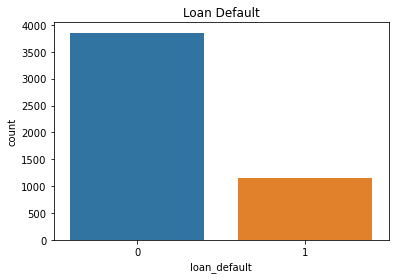

In [6]:
sns.countplot(x='loan_default', data = Data)
plt.title("Loan Default")

Vemos que alrededor del 20 al 25 por ciento de todos los préstamos en el conjunto de datos incumplieron.

#### 1.2 

Hacer un histograma para el annual income

Text(0.5, 0, 'Annual Income')

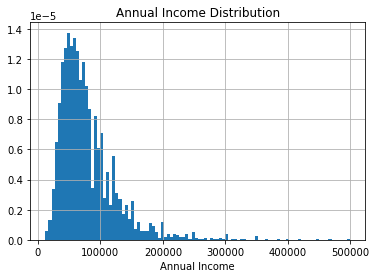

In [7]:
Data.annual_inc.hist(bins=100, density=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")

Vemos que los datos están bastante sesgados. Probemos una transformación logarítmica para que los datos se distribuyan de manera más normal:

Text(0.5, 0, 'Annual Income')

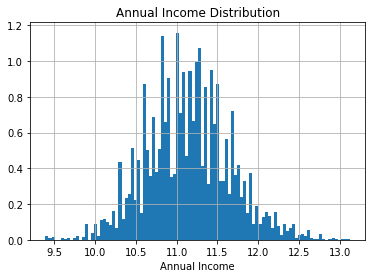

In [8]:
np.log(Data.annual_inc).hist(bins=100, density=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")

#### 1.3

¿Es diferente la distribución de los ingresos anuales entre los solicitantes que incumplieron y los solicitantes que no incumplieron sus préstamos?

Text(0.5, 1.0, 'Annual Salary -- Loan Status')

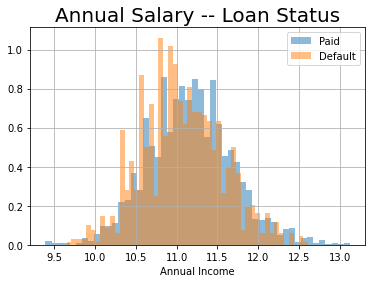

In [9]:
np.log(Data['annual_inc'][Data.loan_default == 0]).hist(bins=50, density=True, alpha=0.5, label="Paid")
np.log(Data['annual_inc'][Data.loan_default == 1]).hist(bins=50, density=True, alpha=0.5, label="Default")
plt.xlabel("Annual Income")
plt.legend()
plt.title("Annual Salary -- Loan Status", fontsize=20)

Podemos ver que las distribuciones no son tan diferentes, lo que indica que es probable que los ingresos por sí solos no expliquen una fracción significativa de la diferencia en el estado de incumplimiento de los préstamos.

#### 1.4

Explora la asociación entre el ingreso anual y la cuota mensual.

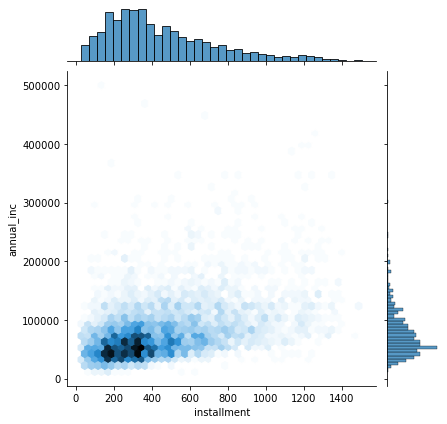

In [10]:
sns.jointplot(Data.installment, Data.annual_inc, kind="hex")

Esto muestra que las distribuciones de ambas variables están sesgadas de manera similar. Esto significa que ambos deben someterse a una transformación:

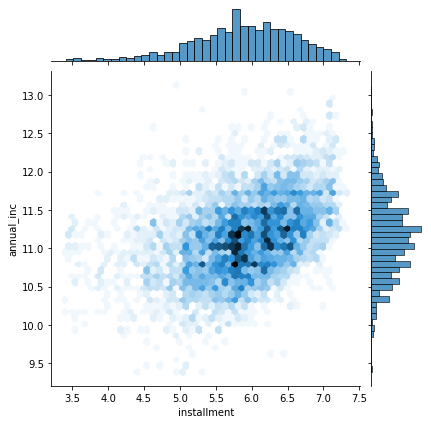

In [11]:
sns.jointplot(np.log(Data.installment), np.log(Data.annual_inc), kind="hex")

Esto se ve mucho mejor y parece sugerir (con algunos valores atípicos en el extremo izquierdo) una relación lineal entre los logaritmos de ambas variables.

Aquí hay algunas cifras más que analizan la relación entre otras covariables numéricas y la probabilidad de incumplimiento, así como el ingreso anual:

`emp_length`:

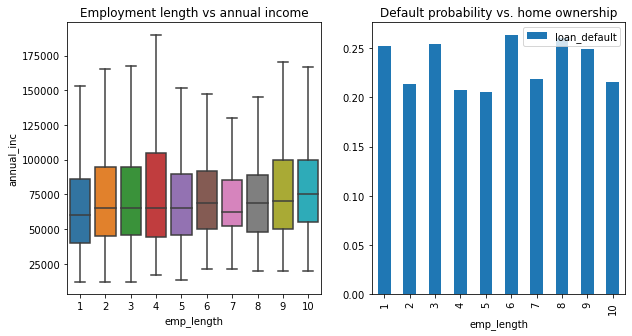

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x='emp_length', y = 'annual_inc', data = Data, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Employment length vs annual income")
Data[["emp_length",'loan_default']].groupby("emp_length").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership");

`homeOwnership`:

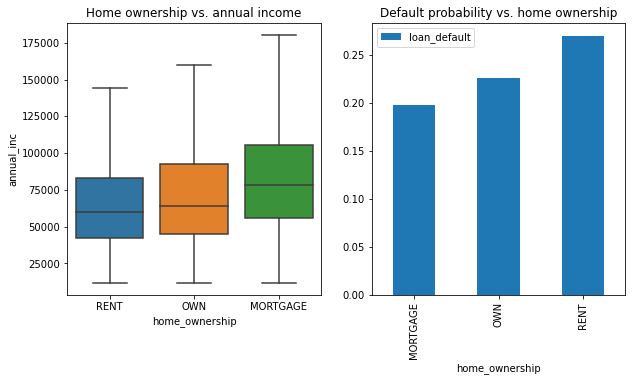

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x="home_ownership",y="annual_inc", data = Data, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Home ownership vs. annual income")
Data[["home_ownership",'loan_default']].groupby("home_ownership").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership");

Aquí hay algunas cifras que muestran la relación entre varias variables categóricas y la probabilidad de incumplimiento:

`purpose`:

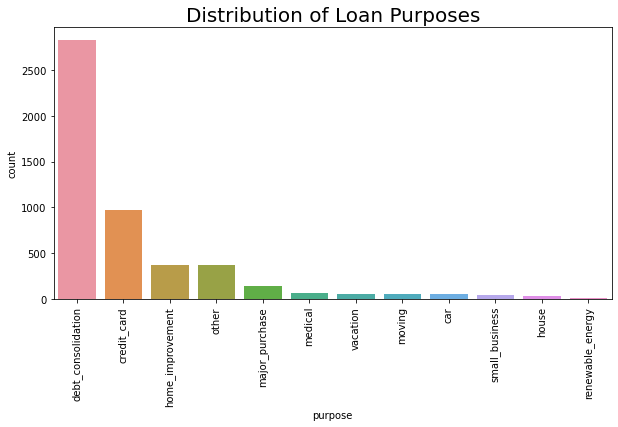

In [14]:
plt.figure(figsize= (10,5))
Data.emp_length.value_counts()
sns.countplot(x='purpose', order=Data['purpose'].value_counts().index, data = Data) 
plt.xticks(rotation=90)
plt.title("Distribution of Loan Purposes", fontsize=20);

In [18]:
Data[["loan_default", "purpose"]].head()

,loan_default,purpose
575,0,debt_consolidation
1311,0,debt_consolidation
4388,0,debt_consolidation
581,0,debt_consolidation
195,0,moving


Text(0.5, 1.0, 'Default Probability by Loan Purpose')

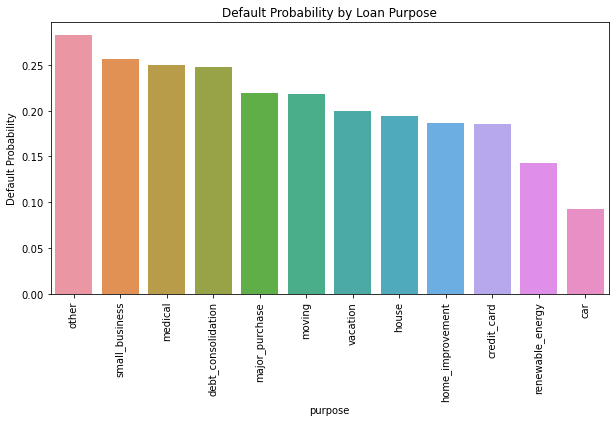

In [15]:
plt.figure(figsize= (10,5))
purpose_default = Data[["loan_default", "purpose"]].groupby("purpose").mean()
purpose_default = purpose_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=purpose_default.index[:30], 
            y=purpose_default["loan_default"][:30].values,
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Default Probability");
plt.title("Default Probability by Loan Purpose")


`job`:

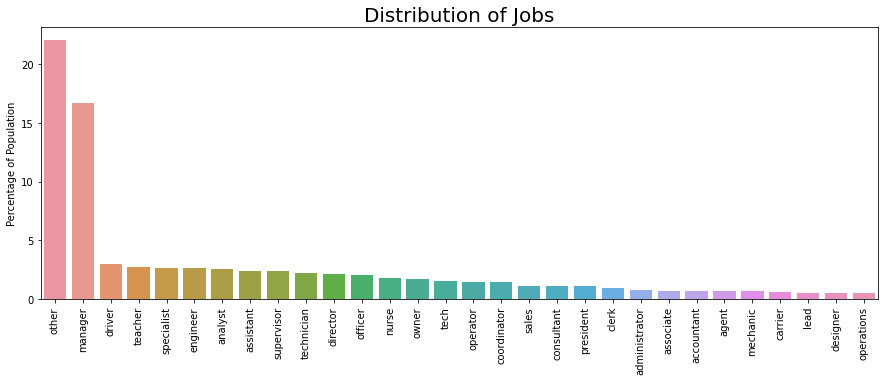

In [19]:
plt.figure(figsize= (15,5))
sns.barplot(x=Data["job"].value_counts()[:30].index.values , 
            y=100 * Data.job.value_counts()[:30].values / len(Data),
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Jobs", fontsize=20);

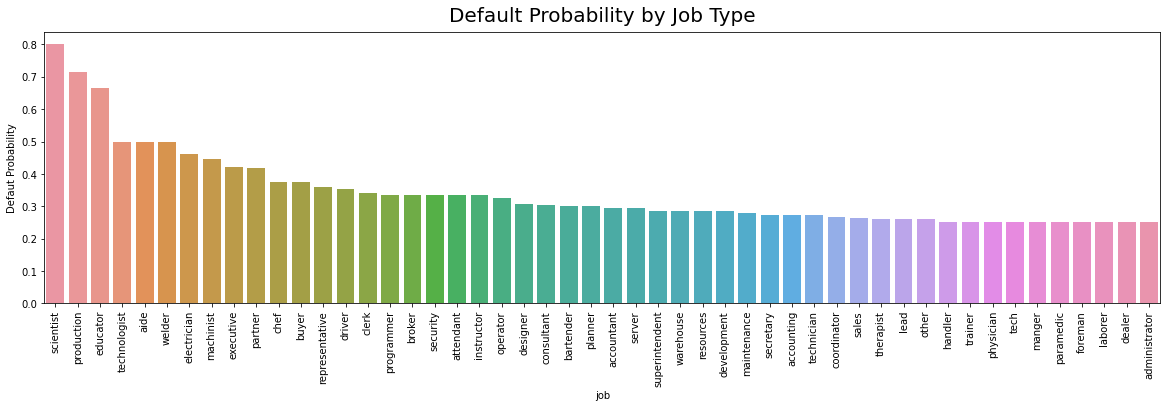

In [20]:
plt.figure(figsize= (20,5))

df_job_default = Data[["loan_default", "job"]].groupby("job").mean()
df_job_default = df_job_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_job_default.index[:50], 
            y=df_job_default["loan_default"][:50].values,
            orient="v")
plt.xticks(rotation=90)

plt.ylabel("Defaut Probability")
plt.title("Default Probability by Job Type", fontsize=20, verticalalignment='bottom');

### Agregando una nueva variable

El pago anual adeudado por el prestamista, como una fracción de su ingreso anual, es una métrica estándar utilizada para evaluar si se debe emitir un préstamo. Definamos una nueva variable **"install_income"** que codifique la cuota como una fracción de los ingresos anuales y estudiemos su asociación con las demás características:

Text(0.5, 0, 'Installment / Income')

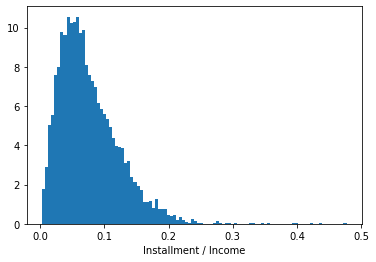

In [21]:
Data['install_income'] = 12 * Data.installment / Data.annual_inc
H = plt.hist(Data['install_income'], bins=100, density=True)
plt.xlabel(r"Installment / Income")

Para investigar fácilmente la asociación de esta variable con la probabilidad de incumplimiento, defina una nueva covariable llamada `install_income_disc` que es una versión discretizada de `install_income`:

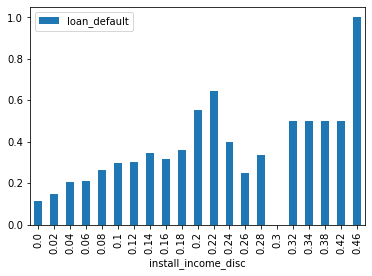

In [22]:
# let us discretize the "install_income" variable to study the probability of default 
# as a function of "install_income"
Data["install_income_disc"] = (Data.install_income*50).astype(int)/50.  #discretization
Data[["loan_default", "install_income_disc"]].groupby("install_income_disc").mean().plot.bar(rot=90)
Data = Data.drop(["install_income_disc"], axis=1)
# --> there is a clear positive association: as the fraction of the annual income devoted to the re-imbursement of 
# the loan increases, the probability of default sharply increases

### Ejercicio 2

Visualice la matriz de correlación en todas las funciones numéricas mediante el comando `sns.heatmap()`:

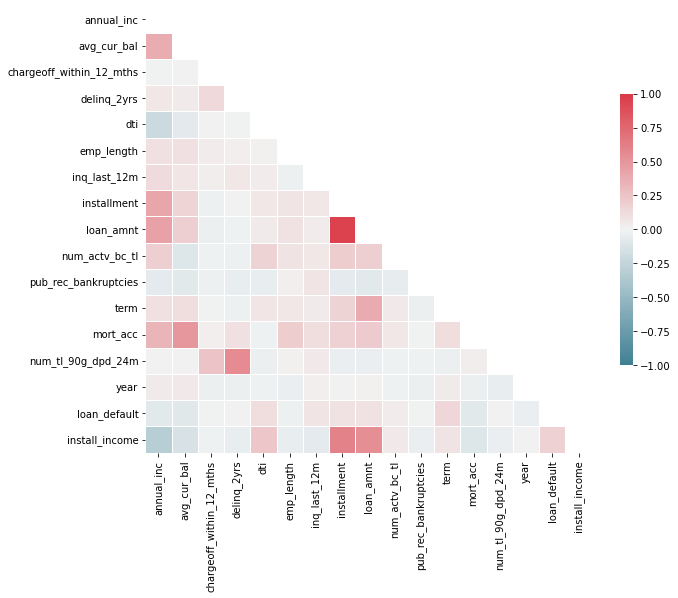

In [23]:
#compute correlation matrix
df_correlations = Data.corr()

#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (10,10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Generando un modelo predictivo

Comencemos primero por construir un modelo de regresión logística estándar. En general, es importante y extremadamente útil crear primero modelos básicos/simples que puedan compararse posteriormente con modelos más complejos.

### Ejerciico 3

#### 3.1

Usando la función `LogisticRegression()` de `scikit-learn`, escriba una función llamada `fit_logistic_regression(X,y)` que ajuste una regresión logística en la matriz de covariables `X` y la variable de respuesta asociada `y`.

In [24]:
from sklearn.linear_model import LogisticRegression
def fit_logistic_regression(X,y):
    """
    fit a logistic regression with feature matrix X and binary output y
    """
    clf = LogisticRegression(solver='lbfgs', tol=10**-4,  
                             fit_intercept=True, 
                             multi_class='multinomial').fit(X,y)
    return clf

#### 3.2

Cree un modelo de regresión logística básico para predecir el incumplimiento del préstamo con una sola característica: `install_income`. Llame a este modelo `modelo1`. Use una división de datos de prueba de tren 70/30.

In [25]:
# we will use a 70%/30% split for training/validation
n_total = len(Data)
n_train = int(0.7*n_total)

X, y = Data[["install_income"]], Data.loan_default
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

In [26]:
model1 = fit_logistic_regression(X_train, y_train)  # fit a logistic regression
y_test_pred = model1.predict_proba(X_test)[:,1]     # make probabilistic predictions on test set

#### 3.3

Traza la curva ROC del `modelo1` y encuentra el área bajo la curva.

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

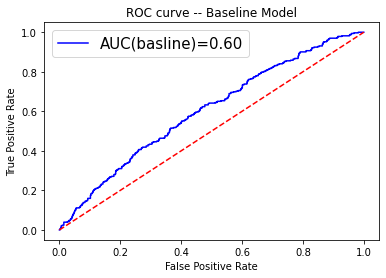

In [28]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)  #compute FPR/TPR
auc_baseline = auc(fpr, tpr) # compute AUC

plt.plot(fpr, tpr, "b-", label="AUC(basline)={:2.2f}".format(auc_baseline))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("ROC curve -- Baseline Model");

### Ejercicio 4

#### 4.1

Considere `model1` desde arriba. ¿Te gustaría que este fuera tu último modelo? ¿Por qué o por qué no?

**Respuesta.** Este no debería ser el modelo final. Esto se debe a que no hemos explorado la contribución de otras variables, que además de contener información valiosa también podrían confundir el efecto percibido de `install_income` en la variable de respuesta. Esta infraexplotación de la información se denomina **underfitting**.


#### 4.2

En su lugar, coloquemos todas las variables disponibles en el modelo, de modo que aprovechemos al máximo nuestra información disponible. ¿Estarías a favor de esto o no?

**Respuesta.** Esta también es una mala idea. Si usamos *a ciegas* todas las variables en el ajuste de nuestro modelo, se produce un fenómeno llamado **sobreajuste**. Esto es cuando un modelo estadístico "se ajusta" demasiado a un conjunto particular de datos, que bien puede ser ruidoso y exhibir aleatoriedad y, por lo tanto, no puede predecir futuras observaciones diferentes de manera confiable.

## Cross-validation

**La validación cruzada** es un conjunto de técnicas para evaluar qué tan bien se generalizarán los resultados de un modelo a un conjunto de datos fuera de la muestra; es decir, en la práctica o la producción. Se utiliza principalmente para marcar el sobreajuste.

La validación cruzada funciona de la siguiente manera: se dividen los datos disponibles en conjuntos de $k$ o **pliegues (folds)**. $k - 1$ de estos pliegues se usará para entrenar el modelo, mientras que el pliegue retenido se usará como conjunto de prueba en el que se evalúa el modelo. Para la estabilidad computacional, este procedimiento generalmente se divide muchas veces, de modo que cada pliegue tenga la oportunidad de servir como conjunto de prueba. Para cada repetición, se calcula una métrica de rendimiento de predicción (por ejemplo, AUC) en el conjunto de prueba. Luego se informa el promedio de estas métricas, así como su desviación estándar. Aquí se muestra un ejemplo para la validación cruzada de 5 veces:


![](cv_fig.png)

Hagamos esto con código. El siguiente código muestra los 5 pliegues diferentes utilizados en un enfoque estándar de validación cruzada de 5 folds. Para hacerlo, use la función `StratifiedKFold()` de `scikit-learn`:

Text(0.5, 1.0, 'CROSS VALIDATION FOLDS')

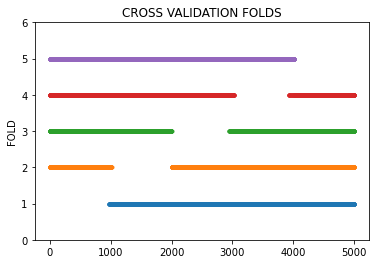

In [29]:
skf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
    plt.plot(train_index, [k+1 for _ in train_index], ".")
plt.ylim(0,6)
plt.ylabel("FOLD")
plt.title("CROSS VALIDATION FOLDS")

El siguiente código define una función `compute_AUC(X, y, train_index, test_index)` que calcula el AUC de un modelo entrenado en "train_index" y probado en "test_index".

In [30]:
def compute_AUC(X, y, train_index, test_index):
    """
    feature/output: X, y
    dataset split: train_index, test_index
    """
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf = fit_logistic_regression(X_train, y_train)
    default_proba_test = clf.predict_proba(X_test)[:,1]  
    fpr, tpr, _ = roc_curve(y_test, default_proba_test)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr

### Ejercicio 5

Con la ayuda de la función `compute_AUC` definida anteriormente, escriba una función `cross_validation_AUC(X,y,nfold)` que realice una validación cruzada de 10 veces y devuelva una lista que contenga el área bajo la curva para cada pliegue de la validación cruzada.

In [31]:
def cross_validation_AUC(X,y, nfold=10):
    """
    use a n-fold cross-validation for computing AUC estimates
    """
    skf = StratifiedKFold(n_splits=nfold)  #create a cross-validation splitting
    auc_list = [] #this list will contain the AUC estimates associated with each fold
    for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
        auc_score, _, _ = compute_AUC(X, y, train_index, test_index)
        auc_list.append(auc_score)
    return auc_list

Ahora estimaremos y compararemos, a través de un análisis de validación cruzada, el desempeño de todos los "modelos simples" que solo usan una característica numérica como entrada. Como se discutió en la sección EDA, usaremos la transformación logarítmica para las variables `anual_income`, `loan_amount` y `avg_cur_bal`:

In [32]:
# let us extract only the numerical (i.e non-categorical) features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Data_numerics = Data.select_dtypes(include=numerics)
Data_numerics = Data_numerics.drop(["installment", "year"], axis=1)

# Using a log scale when appropriate
Data_numerics["annual_inc"] = np.log10(Data_numerics["annual_inc"])
Data_numerics["loan_amnt"] = np.log10(Data_numerics["loan_amnt"])
Data_numerics["avg_cur_bal"] = np.log10(1.+Data_numerics["avg_cur_bal"])

Calculemos las estimaciones de validación cruzada del AUC para cada modelo de una sola característica:

In [33]:
model_perf = pd.DataFrame({}) #this data-frame will contain the AUC estimates
for key in Data_numerics.keys():
    if key == "loan_default": continue
    X_full, y_full = Data_numerics[[key]], Data_numerics.loan_default
    auc_list = cross_validation_AUC(X_full, y_full, nfold=10)
    model_perf["SIMPLE:" + key] = auc_list

### Ejercicio 6

Construya un diagrama de caja que muestre la distribución de las puntuaciones de validación cruzada de cada variable (recuerde, cada variable tiene 10 puntuaciones totales). ¿Qué característica tiene el poder predictivo más alto o más bajo?

In [34]:
def plot_boxplot_ordered(df_model):
    """
    display a list of boxplot, ordered by the media values
    """
    df = df_model[df_model.median().sort_values().index]
    sns.boxplot(x="variable", y="value", data=pd.melt(df), showfliers=False)
    plt.xticks(rotation=90)

Text(0, 0.5, 'AUC')

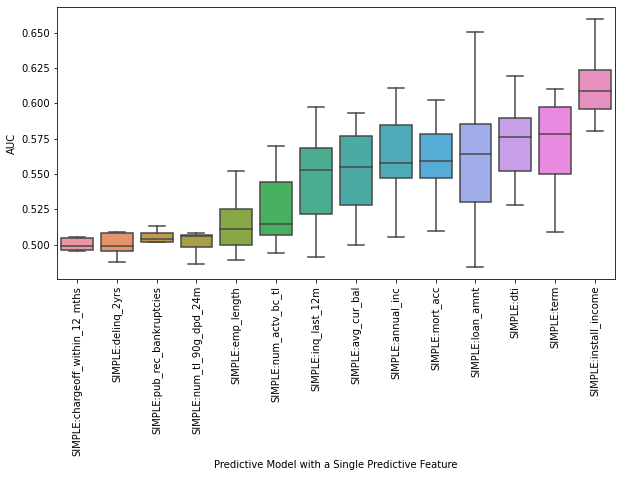

In [35]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

### Ejercicio 7

Considere el modelo que consiste en usar *todas* las características numéricas (y ninguna de las características categóricas). Realice un análisis de validación cruzada de 10 veces para determinar si este modelo tiene un mejor rendimiento predictivo que el mejor modelo de función única. Use el método de diagrama de caja nuevamente como lo hicimos en el Ejercicio 7.

In [36]:
X_full, y_full = Data_numerics.drop(["loan_default"], axis=1), Data_numerics.loan_default
auc_list = cross_validation_AUC(X_full, y_full)
model_perf["ALL_NUMERICAL"] = auc_list
model_perf

,SIMPLE:annual_inc,SIMPLE:avg_cur_bal,SIMPLE:chargeoff_within_12_mths,SIMPLE:delinq_2yrs,SIMPLE:dti,SIMPLE:emp_length,SIMPLE:inq_last_12m,SIMPLE:loan_amnt,SIMPLE:num_actv_bc_tl,SIMPLE:pub_rec_bankruptcies,SIMPLE:term,SIMPLE:mort_acc,SIMPLE:num_tl_90g_dpd_24m,SIMPLE:install_income,ALL_NUMERICAL
0,0.545678,0.548507,0.505181,0.487388,0.527986,0.489433,0.491467,0.567664,0.501375,0.488444,0.568426,0.555472,0.507704,0.604445,0.633011
1,0.509999,0.499784,0.496409,0.506863,0.584390,0.498159,0.508829,0.591060,0.494364,0.508772,0.605604,0.509579,0.505534,0.613081,0.634783
2,0.505159,0.521294,0.503397,0.494307,0.600275,0.504000,0.554006,0.650282,0.508817,0.505534,0.598923,0.576982,0.486138,0.659281,0.724389
3,0.569486,0.548617,0.495223,0.465601,0.591146,0.551779,0.551451,0.601502,0.547487,0.501942,0.591304,0.545929,0.496047,0.680068,0.683230
4,0.564111,0.575968,0.496951,0.499164,0.568628,0.498837,0.551248,0.567747,0.533394,0.512987,0.587804,0.587374,0.487476,0.625703,0.694500
5,0.550954,0.592953,0.505195,0.508594,0.583433,0.503478,0.570977,0.539627,0.566844,0.502033,0.552230,0.551429,0.506934,0.580113,0.631801
6,0.595054,0.511361,0.497820,0.498408,0.619130,0.539752,0.512016,0.514613,0.513247,0.506155,0.542631,0.538250,0.506392,0.603885,0.622631
7,0.611146,0.581683,0.499548,0.531756,0.543794,0.527555,0.574297,0.484472,0.515325,0.509362,0.549577,0.578713,0.505206,0.587182,0.655381
8,0.590017,0.577606,0.495652,0.508458,0.567149,0.518125,0.560090,0.526968,0.506606,0.476477,0.609938,0.602157,0.506053,0.593710,0.696465
9,0.550378,0.561796,0.505195,0.499514,0.546787,0.517651,0.597425,0.559932,0.570107,0.502067,0.508752,0.562688,0.507962,0.617403,0.628752


Text(0, 0.5, 'AUC')

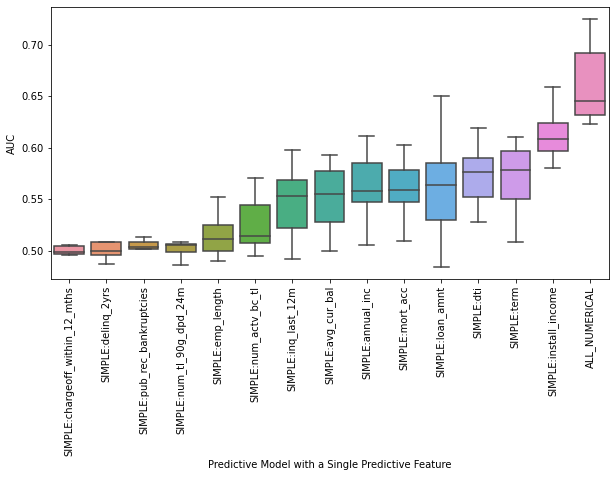

In [37]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

Vemos que el modelo combinado funciona mejor que el mejor modelo de función única. Por lo tanto, seguiremos adelante con el resto de este caso. Tenga en cuenta, sin embargo, que la mejor práctica implicaría agregar funciones de forma iterativa al mejor modelo de una sola función hasta llegar a un punto en el que no haya una mejora significativa, en lugar de incluir todas las funciones a la vez. Te recomiendo este enfoque más cauteloso cuando construyas tus propios modelos.

## Incorporando variables categoricas

La calificación de un préstamo (es decir, la función de calificación de préstamo asignada por LC) no se ha utilizado hasta ahora. La siguiente es la distribución de la función de calificación categórica:

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'B'),
  Text(1, 0, 'F'),
  Text(2, 0, 'C'),
  Text(3, 0, 'E'),
  Text(4, 0, 'D'),
  Text(5, 0, 'A'),
  Text(6, 0, 'G')])

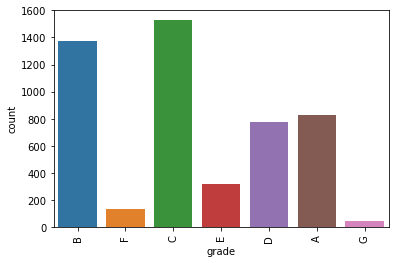

In [38]:
Data.emp_length.value_counts()
sns.countplot(x='grade', data = Data) 
plt.xticks(rotation=90)

### Ejercicio 8

#### 8.1

Usa `pandas.get_dummies()` para transformar esto en su versión codificada one-hot.

In [39]:
#use a one-hot-encoding approach for incorporating the "grade" categorical variable
grade_categ = pd.get_dummies(Data['grade'], prefix = "grade", drop_first=True)
grade_categ.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
575,1,0,0,0,0,0
1311,0,0,0,0,1,0
4388,1,0,0,0,0,0
581,0,1,0,0,0,0
195,0,1,0,0,0,0


#### 8.2

Agregue esta característica al modelo totalmente numérico de antes e investigue si esto conduce a un aumento significativo en la precisión predictiva.

In [40]:
X_grade = pd.concat([X_full,grade_categ],axis=1) 
X_grade.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,install_income,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
575,5.267172,3.790707,0.0,0.0,12.12,2,7.0,4.602060,3.0,0.0,60,0.0,0.0,0.055038,1,0,0,0,0,0
1311,4.679064,3.519434,0.0,0.0,32.09,5,0.0,4.153815,5.0,0.0,36,0.0,0.0,0.142566,0,0,0,0,1,0
4388,5.041393,4.516509,0.0,0.0,30.29,10,0.0,4.397940,6.0,0.0,36,6.0,0.0,0.085955,1,0,0,0,0,0
581,4.518514,4.010342,0.0,0.0,31.89,10,1.0,3.698970,5.0,0.0,36,4.0,0.0,0.061695,0,1,0,0,0,0
195,4.354108,3.338656,0.0,0.0,26.29,4,0.0,3.720159,4.0,0.0,36,0.0,0.0,0.097991,0,1,0,0,0,0


In [41]:
auc_list = cross_validation_AUC(X_grade, y_full)
model_perf["ALL_NUMERICAL_WITH_GRADE"] = auc_list

Text(0, 0.5, 'AUC')

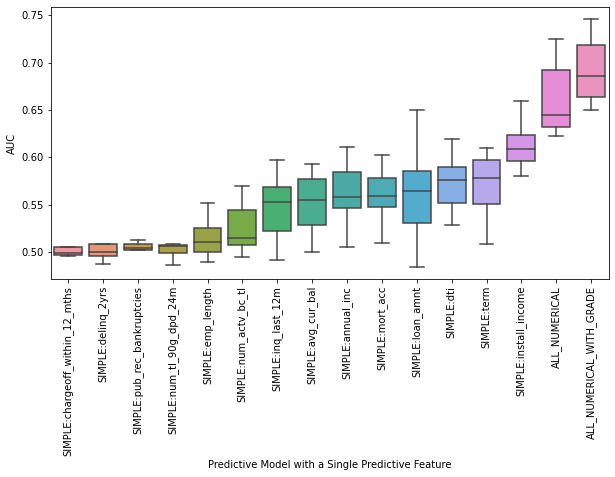

In [42]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

La diferencia parece significativa ya que el diagrama de caja del modelo actualizado casi no se superpone con el del modelo anterior.

### Ejercicio 9

Investigue si la variable categórica `job` aporta algún valor predictivo cuando se agrega al mejor modelo actual. Una vez más, es posible que desee utilizar un esquema de codificación one-hot.

Text(0.5, 1.0, 'Default Rate per Employment Type')

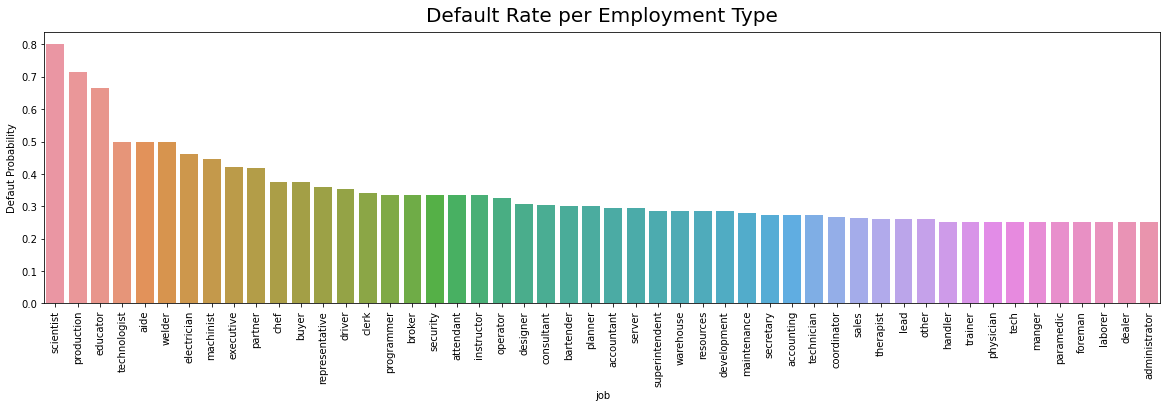

In [43]:
plt.figure(figsize= (20,5))

df_job_default = Data[["loan_default", "job"]].groupby("job").mean()
df_job_default = df_job_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_job_default.index[:50], 
            y=df_job_default["loan_default"][:50].values,
            orient="v")
plt.xticks(rotation=90)

plt.ylabel("Defaut Probability")
plt.title("Default Rate per Employment Type", fontsize=20, verticalalignment='bottom')


In [44]:
#use a one-hot-encoding approach for incorporating the "purpose" categorical variable
job_categ = pd.get_dummies(Data['job'], prefix = "job", drop_first=True)

In [45]:
X_grade_job = pd.concat([X_grade,job_categ],axis=1) 
X_grade_job.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,...,job_technician,job_technologist,job_teller,job_therapist,job_trainer,job_underwriter,job_vp,job_warehouse,job_welder,job_worker
575,5.267172,3.790707,0.0,0.0,12.12,2,7.0,4.602060,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1311,4.679064,3.519434,0.0,0.0,32.09,5,0.0,4.153815,5.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4388,5.041393,4.516509,0.0,0.0,30.29,10,0.0,4.397940,6.0,0.0,...,0,0,0,0,0,0,0,0,0,0
581,4.518514,4.010342,0.0,0.0,31.89,10,1.0,3.698970,5.0,0.0,...,0,0,0,0,0,0,0,0,0,0
195,4.354108,3.338656,0.0,0.0,26.29,4,0.0,3.720159,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
X_grade_job.keys()
# --> 138 features

Index(['annual_inc', 'avg_cur_bal', 'chargeoff_within_12_mths', 'delinq_2yrs',
       'dti', 'emp_length', 'inq_last_12m', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies',
       ...
       'job_technician', 'job_technologist', 'job_teller', 'job_therapist',
       'job_trainer', 'job_underwriter', 'job_vp', 'job_warehouse',
       'job_welder', 'job_worker'],
      dtype='object', length=138)

In [47]:
len(X_grade_job.keys())

138

In [48]:
auc_list = cross_validation_AUC(X_grade_job, y_full)
model_perf["ALL_NUMERICAL_WITH_GRADE_JOB"] = auc_list

Text(0, 0.5, 'AUC')

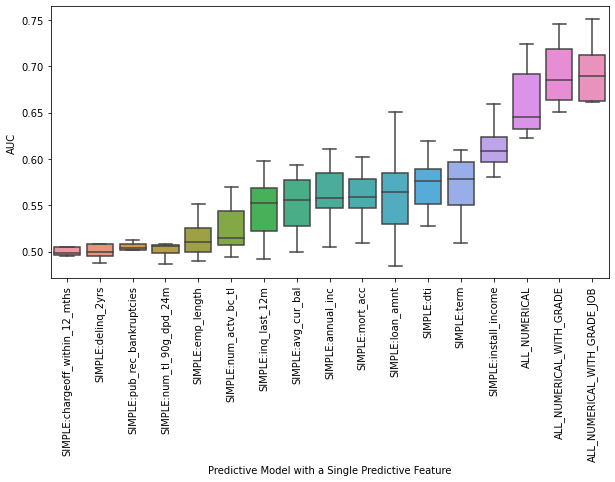

In [49]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

Podemos ver que los diagramas de caja se superponen significativamente, por lo que no hay un beneficio perceptible. Podemos repetir este proceso con otras variables categóricas para construir iterativamente el modelo más simple posible.

## Conclusiones

En este caso, primero exploramos el conjunto de datos de préstamos y encontramos las asociaciones de una sola variable entre las características disponibles y la tasa de incumplimiento. También descubrimos qué características requerían transformaciones (por ejemplo, transformación de registro).

Una vez que comenzamos a construir modelos, comenzamos con enfoques de regresión logística muy simples: estos modelos de referencia fueron útiles para evaluar rápidamente el poder predictivo de cada variable individual. Luego, empleamos enfoques de validación cruzada para construir modelos más complejos, a menudo explotando las interacciones entre las diferentes características. Dado que el conjunto de datos del préstamo contiene una gran cantidad de covariables, se reveló que el uso de la validación cruzada es crucial para evitar el sobreajuste, elegir la cantidad correcta de características y, en última instancia, elegir un modelo apropiado que equilibre la complejidad con la precisión.

## Para llevar

La validación cruzada es una técnica sólida y flexible para evaluar el rendimiento predictivo de los modelos estadísticos. Es especialmente útil en configuraciones de big data donde la cantidad de características es grande en comparación con la cantidad de observaciones. Cuando se usa adecuadamente, la validación cruzada es un método poderoso para elegir un modelo con la complejidad correcta y el mejor rendimiento predictivo.